In [1]:
import pandas as pd
import numpy as np

# Load the tick data
df = pd.read_csv('XAUUSD_tick_Train.csv', parse_dates=['timestamp'],)

# Ensure correct time format and indexing
# df.set_index('timestamp', inplace=True)


In [2]:
# Ensure the timestamp is datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce', infer_datetime_format=True)

df.set_index('timestamp', inplace=True)

# Calculate mid-price
df['mid_price'] = (df['bidPrice'] + df['askPrice']) / 2

# Calculate delta volume (aggressive buying minus aggressive selling)
df['delta_volume'] = df['askVolume'] - df['bidVolume']

# Resample to 1-minute candles
minute_df = df.resample('1T').agg({
    'bidPrice': 'last',
    'askPrice': 'last',
    'bidVolume': 'sum',
    'askVolume': 'sum',
    'mid_price': 'last',
    'delta_volume': 'sum'
}).dropna()

# Calculate cumulative volume delta (CVD)
minute_df['CVD'] = minute_df['delta_volume'].cumsum()

# Function for Volume Profile calculation (aggregating by price bins)
def volume_profile(df, interval='5T', bin_size=0.1):
    df = df.copy()
    df['price_bin'] = (df['mid_price'] / bin_size).round() * bin_size
    vp = df.groupby([pd.Grouper(freq=interval), 'price_bin'])[['bidVolume', 'askVolume']].sum()
    vp['total_volume'] = vp['bidVolume'] + vp['askVolume']
    vp = vp['total_volume'].unstack(fill_value=0)
    return vp

# Calculate volume profile
vp = volume_profile(df, '5T', bin_size=0.1)

# Display outputs
print("Minute-level data with CVD:")
print(minute_df.head())

print("\nExample Volume Profile:")
print(vp.head())


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11916\119175525.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce', infer_datetime_format=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11916\119175525.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_df = df.resample('1T').agg({
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11916\119175525.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  vp = df.groupby([pd.Grouper(freq=interval), 'price_bin'])[['bidVolume', 'askVolume']].sum()


Minute-level data with CVD:
                           bidPrice  askPrice  bidVolume  askVolume  \
timestamp                                                             
2019-12-29 23:00:00+00:00  1511.418  1511.852    0.10744    0.05306   
2019-12-29 23:01:00+00:00  1511.368  1511.822    0.06374    0.07682   
2019-12-29 23:02:00+00:00  1511.348  1511.832    0.04084    0.04590   
2019-12-29 23:03:00+00:00  1511.238  1511.722    0.02502    0.02558   
2019-12-29 23:04:00+00:00  1511.228  1511.672    0.03672    0.03590   

                           mid_price  delta_volume      CVD  
timestamp                                                    
2019-12-29 23:00:00+00:00   1511.635      -0.05438 -0.05438  
2019-12-29 23:01:00+00:00   1511.595       0.01308 -0.04130  
2019-12-29 23:02:00+00:00   1511.590       0.00506 -0.03624  
2019-12-29 23:03:00+00:00   1511.480       0.00056 -0.03568  
2019-12-29 23:04:00+00:00   1511.450      -0.00082 -0.03650  

Example Volume Profile:
price_bin      

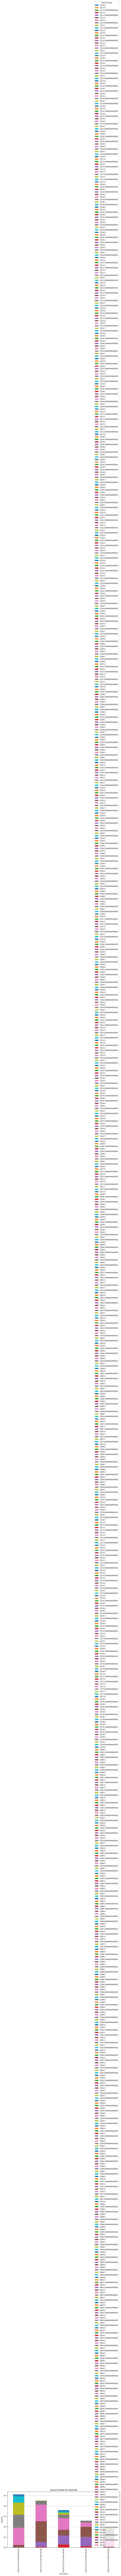

In [3]:
#Plot the Volume Profile
import matplotlib.pyplot as plt
def plot_volume_profile(vp, title='Volume Profile'):
    vp.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Price Bins')
    plt.ylabel('Volume')
    plt.legend(title='Volume Type')
    plt.grid(axis='y')
    plt.show()
    
# Plot the Volume Profile
plot_volume_profile(vp.head(), title='Volume Profile for XAUUSD')
# Plot the Cumulative Volume Delta